In [1]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene

In [2]:
# Works for MODIS and S3 .L2.OC.x.nc files #
#  Test for MERIS
files = glob('/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.*.L2.OC.x.nc')
files

['/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100910T193000.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100927T183501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100930T190501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100926T193000.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100911T201501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100915T195000.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100912T192000.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100928T191500.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100920T182501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.20100906T195501.L2.OC.x.nc',
 '/home/hb

# OPENING FILES, PUTING THEM IN A COMMON GRID, AND SAVING A COMBINED FILE

In [3]:
# Functions to be used

def convtoxr(scn, var):
    #convert from dask array
    data = scn[var].load()
    data.name = var
    del(data.attrs['_satpy_id']) ### removing, we don't need this.
    data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
    return data

def load_satdata(path, 
                 area_deff=None,
                 res=None,
                 name="GOMEX", proj={"proj": "laea"}, area_extent=(-91, 28, -88, 31),
                ):
#   get data and attributes
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    attrs = xr.open_dataset(path).attrs
    
#   area definition if not defined
    if res is None:
        # get the resolution of the Sat product
        val, unit = attrs['spatialResolution'].split()
        res  = xr.DataArray(float(val), attrs={"units": unit})
    if area_deff is None:
        area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)
        
#   reprojecting
    scn = Scene()
    swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
    vnames = [v for v in data.data_vars if 'Rrs' in v]
    for var in vnames:
        scn[var] = data[var]
        scn[var].attrs["area"] = swath_def
    resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
    resampled_scn.compute()
    lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
    
#   Converting back to xarray dataset
    ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
    ds.attrs = attrs
    ds = ds.assign_coords({
                            'lon': (('y', 'x'), lons),
                            'lat': (('y', 'x'), lats),
                            'time': pd.to_datetime(attrs['time_coverage_start'])
                            })
#   getting rid of the crs coord
    # ds.attrs['crs'] = ds.crs
    ds = ds.drop('crs')
    print(str(ds.time.data))
    return ds

In [4]:
# Area setup for GOMEX
resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
extent = (-91, 28, -88, 31)
res = xr.DataArray(resval, attrs={"units": "meters"})
lat_0, lon_0 = 28.5, -90.8 # just some rounded up mean from the lat lon range of the sat product
proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
area = create_area_def("GOMEX", proj,
                       area_extent=extent, units="degrees", 
                       resolution=res
                      ) # creating a fixed area to reproject to

# Reprojectig files
dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
combined = xr.concat(dsets, dim='time') #combining in one file


#for naming the file
date = [f.split('.')[1] for f in files]
year = ((date[1])[0:4])
month = ((date[1])[4:6])

#save combined file
# give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite
combined.to_netcdf('/home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODIS/' + year + '_' + month + '_MODIS_L2.nc') 


Rounding shape to (1123, 956) and resolution from (300.0, 300.0) meters to (299.72703443568895, 299.85149942752383) meters
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when conve

2010-09-10T19:30:00.688000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-27T18:35:01.388000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-30T19:05:01.230000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-26T19:30:00.527000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-11T20:15:01.579000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-15T19:50:00.790000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-12T19:20:00.960000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-28T19:15:00.951000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-20T18:25:01.001000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-06T19:55:01.443000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-23T19:00:00.691000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-22T19:55:01.306000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-09T18:45:01.253000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-20T18:30:00.855000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-27T20:15:01.418000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-16T18:50:01.796000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-03T19:25:01.616000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-19T19:25:01.476000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-11T20:10:01.725000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-18T20:20:00.618000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-15T19:45:00.936000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-22T18:15:01.276000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-18T18:40:00.589000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-25T18:45:01.113000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-16T18:55:01.650000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-13T20:00:00.517000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-17T19:35:01.211000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-24T19:40:01.730000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-07T19:00:00.828000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-27T20:10:01.564000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-04T18:30:00.997000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-12T19:15:01.106000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-05T19:10:00.554000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-06T18:15:01.413000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-01T19:35:01.349000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-13T18:20:01.964000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-04T20:05:01.173000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-13T18:25:01.818000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-29T18:20:01.813000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-21T19:10:01.891000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-29T20:00:01.843000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-14T19:05:01.378000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-20T20:05:01.031000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-19T19:20:01.622000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-11T18:35:01.549000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-02T20:20:00.759000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-08T19:40:01.864000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-09-02T18:40:00.729000000


# PLOTTING

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

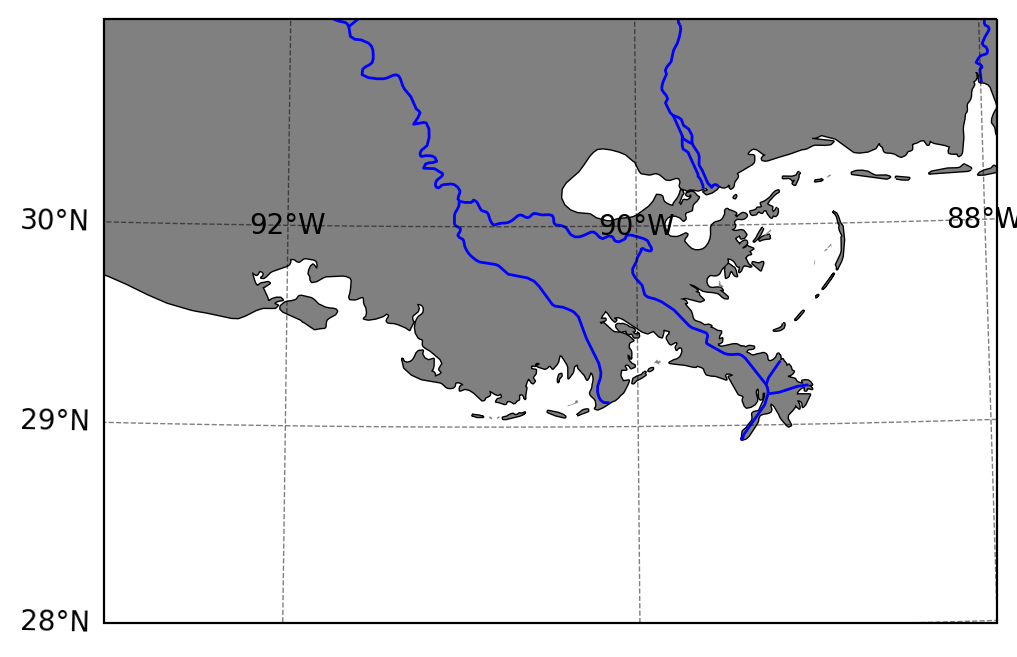

In [6]:
# Map base function
lat_0, lon_0 = 28.5, -90.8

lat_top=31
lat_bot=28
lon_left=-88
lon_rigth=-93
extent=[lon_left, lon_rigth, lat_bot, lat_top]

def plot_mapbase(extent=extent, res='10m', projection=ccrs.PlateCarree(), ax=None):
    if ax is None:
        fig = plt.figure(dpi=200) # set fig size
        ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent , crs=ccrs.PlateCarree())
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))

    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                 ylocs=[28, 29,30], 
                 xlocs=[-94, -92, -90, -88], 
                 draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')
    gl.right_labels = False
    return ax

ax = plot_mapbase(projection= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0))

In [7]:
def get_CDOM(ds, lambd=300):
    '''
    ln(a_CDOM(lambda)) = alpha * ln(Rrs443) + beta * ln(Rrs448)
                        + gamma * ln(Rrs531) + delta * ln(Rrs(555))
                        + epsilon * ln(Rrs667) + zeta
    a_CDOM(300) = (exp(-15.05 - 33.95 * S_275-295)) + exp(-1.502 - 104.3 * S_275-295)
    '''
    if lambd==300:
        alpha = -.0206
        beta = -.6128
        gamma = -.007
        delta = -.4944
        epsilon = .9362
        zeta = .9666
        
    elif lambd==355:
        alpha = .0376
        beta = -.8714
        gamma = -.0352
        delta = -.2739
        epsilon = .9591
        zeta = -.1071
    else:
        print('alg not defined gor lambda={}'.format(lamdb))
        return
        
    aCDOM = np.exp(alpha * np.log(ds.Rrs_443) +
                  beta * np.log(ds.Rrs_488) +
                  gamma * np.log(ds.Rrs_531) +
                  delta * np.log(ds.Rrs_555) +
                  epsilon * np.log(ds.Rrs_667) + zeta)
    
    alpha0 = -.0537
    beta0 = -.2689
    gamma0 = .1017
    delta0 = -.2097
    epsilon0 = -.0893
    zeta0 = -3.6853
    
    S_275_295 = np.exp(alpha0 * np.log(ds.Rrs_443) +
                  beta0 * np.log(ds.Rrs_488) +
                  gamma0 * np.log(ds.Rrs_531) +
                  delta0 * np.log(ds.Rrs_555) +
                  epsilon0 * np.log(ds.Rrs_667) + zeta0)
    
    aCDOM_star = np.exp(-15.05 - 33.95 * S_275_295) + np.exp(-1.502 - 104.3 * S_275_295)
                  
    DOC = aCDOM/aCDOM_star
                  
    print('Returning aCDOM(lambda), SS_275_295 and DOC for lambda ' + str(lambd))
    print('aCDOM({}): CDOM absorption spectra (m-1)'.format(lambd))
    print('SS_275_295: CDOM absorption spectral slope coefficient in the 275–295 nm spectral region (nm-1)')
    print('DOC: Disolved organic carbon (umol L-1)')
    print('according to Cao et. al 2018')
    return aCDOM, S_275_295, DOC

Returning aCDOM(lambda), SS_275_295 and DOC for lambda 300
aCDOM(300): CDOM absorption spectra (m-1)
SS_275_295: CDOM absorption spectral slope coefficient in the 275–295 nm spectral region (nm-1)
DOC: Disolved organic carbon (umol L-1)
according to Cao et. al 2018


ValueError: supplied range of [0.18740950524806976, inf] is not finite

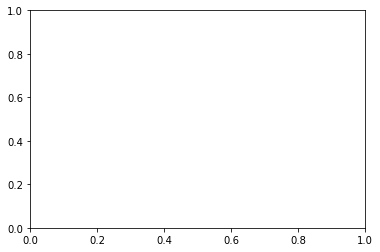

In [13]:
##for testing data set
combined[['aCDOM', 'S_275_295', 'DOC']] = get_CDOM(combined)

combined.S_275_295.plot.hist()

In [ ]:
# Looping through times to plot:


#Need to define GOOD min and max values for colorbar so it is the same for all figures
vmin = 0
# vmax = combined.Rrs_443.max()*10e2 #should probably set to a fix number so all different periods have the same color range
vmax = 5 # FIND A SENSIBLE VALUE FOR VMAX

# arguments for the colorbar
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':30, 'label':'Rrs 443 nm (x 10$^{-2}$ sr$^{-1}$)', 'pad': .01}
# Map projection
map_proj = ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0)

# looping through time dim
for i in range(combined.time.size):
    fig = plt.figure(dpi=200) # set fig size
    ax = fig.add_subplot(111, projection=map_proj)
    plot_mapbase(ax=ax)
    data = combined.aCDOM.isel(time=i) # <<<<< CHANGE THIS FOR PLOTING OTHER VARIABLES
    label = '/home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_{}_.png'.format(str(data.time.values)[:10]) # <<<<< CHANGE NAME IN LABEL 
    print(i, label)
    sat = (10e2*data.where(data>0)).plot(x='lon', y='lat',
                         transform=ccrs.PlateCarree(),
                         cmap='pink_r', vmin=vmin, vmax=vmax,
                         cbar_kwargs=cbar_kwargs,
                         robust=False,
                         ax=ax
                        )
    

    fig.savefig(label)
    plt.close(fig)

/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Returning aCDOM(lambda), SS_275_295 and DOC for lambda 300
aCDOM(300): CDOM absorption spectra (m-1)
SS_275_295: CDOM absorption spectral slope coefficient in the 275–295 nm spectral region (nm-1)
DOC: Disolved organic carbon (umol L-1)
according to Cao et. al 2018
0 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-10_.png
1 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-27_.png
2 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-30_.png
3 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-26_.png
4 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-11_.png
5 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-15_.png
6 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-12_.png
7 /home/hboi-ouri/Projects/NASA_Pr